# Project: Genetic algorithm for Water Distribution Systems

<h1 style="position: absolute; display: flex; flex-grow: 0; flex-shrink: 0; flex-direction: row-reverse; top: 60px;right: 30px; margin: 0; border: 0">
    <style>
        .markdown {width:100%; position: relative}
        article { position: relative }
    </style>
    <img src="https://gitlab.tudelft.nl/mude/public/-/raw/main/tu-logo/TU_P1_full-color.png" style="width:100px; height: auto; margin: 0"\>
    <img src="https://gitlab.tudelft.nl/mude/public/-/raw/main/mude-logo/MUDE_Logo-small.png" style="width:100px; height: auto; margin: 0"\>
</h1>
<h2 style="height: 10px">
</h2>

*[CEGM1000 MUDE](http://mude.citg.tudelft.nl/): Week 2.5. Due: Friday, Dec 15, 2023.*

## 📝 Overview

This is the first part of Project 7, which takes place in Q2, Weeks 5 and 6. In these weeks, we'll apply optimization and machine learning techniques to design water distribution systems.

This notebook has three main parts. The first part is an introduction of more realistic water distribution systems and the problem framing to find the most suitable diameters with a genetic algorithm. The second part exemplifies the use of a genetic algorithm to minimize the cost of a simple system . Finally, the third part is a more complex system for you to solve.

Complete this assignment by the end of the session at 12:30. This means having a single notebook for your group with all code, analysis and interpretation completed. You should leave the cell outputs in the notebook.

### Working Method

We recommend that you select one group member to prepare the "master" notebooks (one for the Linear Programming part, one for this part of the project). Other group members can contribute by writing and checking code or analytic expressions on their own computer or paper and sending to the "master" computer.

**Completition requirements:**

By the end of this notebook, you should have:
- Implemented all the code cells for:
  - Defining the variables, restrictions, and objective functions in the optimization problems
  - Solving the optimization problems using PyMOO
- Interpreted the results of the optimization problems in your own words
- Answered all the questions in the notebook

## 📔 Libraries

<!-- 
# If you have not installed pytorch geometric uncomment the following lines to install it

# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# !pip install wntr -->

To run this notebook you need to have installed the following packages:
- Pandas
- Numpy
- Matplotlib
- WNTR
- PyMOO

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#Library for analysis of Water distribution networks
import wntr

#Genetic algorithm dependencies
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.repair.rounding import RoundingRepair
from pymoo.core.problem import Problem
from pymoo.optimize import minimize
from pymoo.operators.sampling.rnd import IntegerRandomSampling

## 🔙 Background

### 💧 Water distribution systems

As cities grow, so does the challenge of getting water to everyone efficiently. Imagine a giant puzzle where water has to travel from its source, like a reservoir, to homes, stores, and factories. This puzzle gets even trickier in cities because there are many more places that need water, and we need to make sure that if one part of the system breaks, others are still connected. That is why we have large and looped systems as the one in Figure 1.

However, figuring out the best way to design these water networks is a real challenge. Using the methods we learned before, like linear programming, isn't practical anymore. You can imagine the number of constraints that we would need to add to the system. 

We need a different approach.

In this assignment, we're going to use a genetic algorithm to address this problem. In order to reduce some complexity of the problem, each pipe line will have only one diameter. This facilitates the problem; however, there is still an enourmous amount of possibilities to consider.

To help us calculate the hydraulics in the system, we'll use a numerical model for calculating the pressure for all the nodes. This model will help us understand how much pressure there is at different points in the water network. By figuring this out, we can create a system that reliably delivers water to every corner of the city.

<div>
<center><img src="./Images/Modena.png" width="600"/></center>
</div>

Figure 1. Numerical results for the water distribution system in the city of Modena, Italy.

### 🖥Numerical model

WNTR (Water Network Tool for Resilience) is a powerful and flexible Python library designed for modeling, simulating, and analyzing water distribution systems. WNTR is based upon EPANET, which is a widely used software tool for simulating and analyzing these systems. It plays a crucial role in the management and design of water distribution networks by enabling engineers and researchers to model, simulate, and optimize the complex interactions within these systems.

In this notebook, we are going to use this library to compute the pressures at the nodes given diverse configurations of diameters.

<div style="display: flex;">
<center>
    <img src="./Images/Epanet_Logo.png" alt="Image 1" style="width: 18%; height: auto;">
    <img src="./Images/wntr_logo.webp" alt="Image 2" style="width: 50%; height: auto;">
</center>
</div>
Figure 2. EPANET and WNTR logos.



### 🧬Genetic algorithms

Genetic Algorithms (GAs) are powerful optimization techniques inspired by the process of natural evolution. They have gained prominence in solving complex problems across various fields, ranging from engineering and economics to artificial intelligence. Here, we give a brief overview of Genetic Algorithms, highlighting their fundamental principles, components, and applications in solving optimization problems.

At the heart of a Genetic Algorithm are populations of potential solutions, represented as individuals or chromosomes. These individuals evolve over generations to improve their fitness with respect to the given optimization objective.

Basic Components of a Genetic Algorithm:
- **Population**: A collection of individuals representing potential solutions to the problem.
- **Objective Function**: Quantifies the quality of each individual's solution with respect to the optimization objective.
- **Selection**: Individuals are chosen based on their fitness to serve as parents for the next generation.
- **Crossover**: Genetic material from parents is combined to create offspring with potentially improved traits.
- **Mutation**: Random changes are introduced in offspring to maintain diversity and explore new solution spaces.
- **Replacement**: New offspring replace some of the least fit individuals in the population.
- **Termination Criteria**: Conditions under which the algorithm stops, e.g., a maximum number of generations or satisfactory fitness level.

What are the GA's steps?

1. **Initialization**: A population of random individuals is generated to start the algorithm.
2. **Evaluation**: The fitness function assesses the quality of each individual's solution.
3. **Selection**: Individuals with higher fitness have a higher chance of being selected as parents.
4. **Crossover**: Genetic material from selected parents is combined to create offspring.
5. **Mutation**: Random changes are introduced to some offspring to maintain diversity.
6. **Replacement**: New offspring replace some individuals in the population.
7. **Termination**: The algorithm stops when a termination criterion is met.

#### PyMOO Library

PyMOO is a Python library that provides a comprehensive and easy-to-use framework for multi-objective optimization (MOO). For this case, we are going to deal with only one objective; nevertheless, this is an useful tool if you have more objectives. In addition, PyMOO easily allows us to define our optimization problem by specifying the objectives, constraints, and decision variables

## ⛔ Problem definition 

The problem is to find the pipe diameters that minimize the cost of the pipe lines while satisfying the customer demand for water pressure. 

<!-- For this application, we will only consider systems feed by reservoirs that work via gravity. -->

### 🎯 Objective function

We want to minimize the cost of the pipes. Each pipe has a different cost according to its diameter and its length. Generally, the larger the pipe, the more expensive it is. 

We can define the total cost $Z$ of installing all the pipes as the following function
$$
\begin{align}
  & min Z = \sum_{j=1}^{N}C_{j}\sum_{i=1}^{M} L_{ij}\\
\end{align}
$$ (eq_cost_function)

where $C_{j}$ is the cost of pipe per meter-length having diameter $j$.

### 🚫 Restrictions

We consider one main restriction.

1) The water should arrive at the consumer nodes with sufficient pressure. This is, there should be sufficient energy for transporting the water from the source to each of nodes. This restriction can be written as

$$
\sum_{i=1}^{N} H_{i} \leq H^{*} 
$$

<!-- \; \text{for every node i in the system.} -->

## 💻 1. Genetic algorithm - Example

We exemplify the implementation of these algorithms with the system "Two loop network (TLN)". This system consists of one reservoir, six demand nodes and eight pipes organised in two loops. The reservoir has an elevation of 210 m. As a hypothetical network all pipes have the same length (1000 m). The pressure is set to be at least 30.0 m at all demand nodes. The following table shows commercially available diameters and the corresponding unit costs (1 in.=0.0254 m). 

| Diameter [in] | 1    | 2    | 3    | 4    | 6    | 8    | 10   | 12   | 14   | 16   | 18   | 20   | 22   | 24   |
|-------------------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|
| Cost per meter [€/m] | 2    | 5    | 8    | 11   | 16   | 23   | 32   | 50   | 60   | 90   | 130  | 170  | 300  | 500  |


<!-- and the Hazen-Williams coefficient of 130. -->

<div>
<center><img src="./Images/TLN_image.png" width="300"/></center>
</div>


First, let's define some preliminary variables and functions that are going to be used later.

In [2]:
IN_TO_M = 0.0254

cost_function_diameter_inches = {
    1: 2,
    2: 5,
    3: 8,
    4: 11,
    6: 16,
    8: 23,
    10: 32,
    12: 50,
    14: 60,
    16: 90,
    18: 130,
    20: 170,
    22: 300,
    24: 500
}

pipe_index = {
    0:1,
    1:2,
    2:3,
    3:4,
    4:6,
    5:8,
    6:10,
    7:12,
    8:14,
    9:16,
    10:18,
    11:20,
    12:22,
    13:24
    }

H_min = 30

def transform_index_to_diameter(matrix_indexes, pipe_index):
    return np.array([[pipe_index[j] for j in vector_indexes] for vector_indexes in matrix_indexes])

def transform_diameter_to_cost(matrix_indexes, pipe_index):
    return np.array([[pipe_index[j] for j in vector_indexes] for vector_indexes in matrix_indexes])

Here, we use the WNTR library to load the data from TLN. This creates the variable **wn** which stores all the information about the nodes, pipes, reservoirs and other components of the water network.

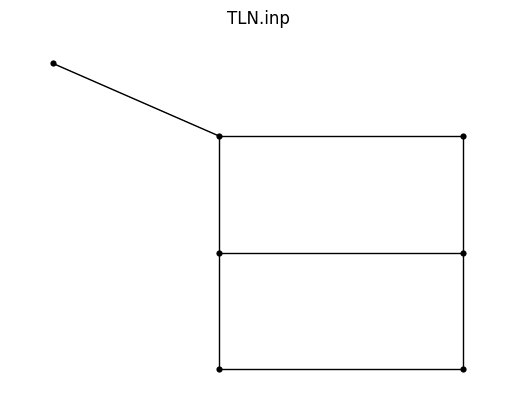

<Axes: title={'center': 'TLN.inp'}>

In [3]:
# Create a water network model
inp_file = 'TLN.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# Graph the network
wntr.graphics.plot_network(wn, title=wn.name)

### PyMOO
Here, we use the PyMOO library to define and solve the optimization problem.

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<b>Task 1.1:</b>   
    Go over the different parts of the initialization of the PyMOO model and answer the following questions:
    <ol>
    <li> What does the 'xl' and 'xu' values represent in the problem definition?</li>
    <li> How does a solution (an individual of the population) looks like? Which type of variable is it? Which values does it contain?</li>
    <li> Give a random example of an individual.  </li>
    </ol>
</div>

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<b>Solution</b><br>
<ol>
    <li> xl is the lower bound of the variable from which the genetic algorithm will create solutions. xu is the upper bound. In this case, the genetic algorithm will suggest the index of the pipe between 0 and 13. </li>
    <li> One individual is a list of integer numbers between 0 and 13. Each of them correspond to a specific diameter according to the dictionary "pipe_index"</li>
    <li> A random example would be: [13, 10,  4, 10,  1,  6, 12,  4]. Notice that they are 8 integer values between 0 and 13.</li> 
</ol>
</div>

In [4]:
#Problem definition:

population_size = 20
class TwoLoopOptimization(Problem):
    def __init__(self):
        #Here, we indicate that our problem has:
        super().__init__(n_var=8,        #8 decision variables (one diameter per pipe)
                         n_obj=1,        #1 objective
                         n_ieq_constr=6, #6 inequality constraints (one pressure value per node)
                         xl=0.0,         #0 as beginning index to search
                         xu=13.0,        #13 as final index to search
                         vtype=int)      #integer as type of variable 
        

    def _evaluate(self, population, out, *args, **kwargs):
        #Here we map the indexes of each individual to the corresponding pipes
        population_in_diameters = transform_index_to_diameter(population, pipe_index)
        pressure_heads   = np.zeros((population_size, 6))
        individual_costs = np.zeros((population_size,1))
        
        #In here, for each individual of the population, we run the numerical simulation
        for i, individual in enumerate(population_in_diameters):
            
            cost = 0
            
            #We iterate over the proposed diameters. For each pipe, we modify the network and add its cost.
            for j, pipe_name in enumerate(wn.pipe_name_list):
                pipe = wn.get_link(pipe_name)
                
                # Modify the water network 
                pipe.diameter = individual[j] * IN_TO_M
                
                # Calculate the cost of the network
                cost += cost_function_diameter_inches[individual[j]] * pipe.length
            
            individual_costs[i] = cost

            #Simulate the water network with the modified individual
            sim = wntr.sim.EpanetSimulator(wn)
            sim_results = sim.run_sim()

            pressure_heads[i,:]= sim_results.node['pressure'].values[0][:-1] #We remove the last node as it is the reservoir
        
        out["F"] = individual_costs          #In F, we store the objective function
        out["G"] = -(pressure_heads - H_min) #In G, we store the restrictions, notice the minus sign as the restrictions are all in the form G <= 0




In [5]:
problem = TwoLoopOptimization()

method = GA(pop_size=population_size,
            sampling=IntegerRandomSampling(),
            crossover=SBX(prob=1.0, eta=3.0, vtype=float, repair=RoundingRepair()), # This type of crossover is used for integer variables
            mutation=PM(prob=1.0, eta=3.0, vtype=float, repair=RoundingRepair()),   # This type of mutation is used for integer variables
            eliminate_duplicates=True,
            )

opt_results = minimize(problem,
               method,
               termination=('n_gen', 100),
               seed=1,
               save_history=True,
               verbose=True,
               )

print("Best solution found: %s" % opt_results.X)
print("Function value: %s" % opt_results.F)
print("Constraint violation: %s" % opt_results.CV)

#To better interpret the results, this is the legend:
#n_gen:  Number of generations
#n_eval: Number of function evaluations
#cv_min: Minimum constraint violation
#cv_avg: Average constraint violation
#f_avg:  Average objective function value
#f_min:  Minimum objective function value

n_gen  |  n_eval  |     cv_min    |     cv_avg    |     f_avg     |     f_min    
     1 |       20 |  1.3939762115 |  3.387608E+06 |             - |             -
     2 |       40 |  0.000000E+00 |  4.328212E+02 |  1.217333E+06 |  8.830000E+05
     3 |       60 |  0.000000E+00 |  7.2960962296 |  1.288800E+06 |  8.830000E+05
     4 |       80 |  0.000000E+00 |  0.000000E+00 |  1.309500E+06 |  8.830000E+05
     5 |      100 |  0.000000E+00 |  0.000000E+00 |  1.060800E+06 |  6.430000E+05
     6 |      120 |  0.000000E+00 |  0.000000E+00 |  9.324500E+05 |  6.430000E+05
     7 |      140 |  0.000000E+00 |  0.000000E+00 |  8.183500E+05 |  6.230000E+05
     8 |      160 |  0.000000E+00 |  0.000000E+00 |  7.590500E+05 |  6.150000E+05
     9 |      180 |  0.000000E+00 |  0.000000E+00 |  6.842000E+05 |  5.610000E+05
    10 |      200 |  0.000000E+00 |  0.000000E+00 |  6.678000E+05 |  5.610000E+05
    11 |      220 |  0.000000E+00 |  0.000000E+00 |  6.466500E+05 |  5.610000E+05
    12 |      24

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<b>Task 1.2:</b>   
    Interpret the results. 
    <ol>
    <li> Why do you think the first generation does not have a value of f_avg and f_min?</li> 
    <li> Which diameters would you order? How much would they cost in total? </li>
    <li> How much is the pressure at the end of the pipe (in meters of hydraulic head)? Are the constraints met? </li>
    </ol>
</div>

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<b>Solution</b><br>
<ol> 
    <li> The first generation produces an entire population of individuals that do not meet the constraints. Therefore, there is no feasible solution from which to report the value of the objective function. </li>
    <li> The diameters of the pipes are [20, 6, 18, 10, 14, 10, 2, 1] inches or [0.508 0.152 0.457 0.254 0.356 0.254 0.051 0.025] mm. They would cost 447000 euros.</li>
    <li> The pressures at each node are [55.96,	30.33,	46.25,	42.63,	30.51,	30.65] meters. All the constraints are met since all the pressures heads are above 30 m.</li>
</ol>
</div>

Evaluate best solution

In [6]:
optimal_diameters = transform_index_to_diameter([opt_results.X], pipe_index)[0]*IN_TO_M
print(optimal_diameters)

[0.508 0.152 0.457 0.254 0.356 0.254 0.051 0.025]


In [7]:
# Modify the water network
for j, pipe_name in enumerate(wn.pipe_name_list):
    pipe = wn.get_link(pipe_name)
    # Modify the water network 
    pipe.diameter = optimal_diameters[j]
    
sim = wntr.sim.EpanetSimulator(wn)
sim_results = sim.run_sim()

In [8]:
sim_results.node['pressure']

name          2          3          4          5          6          7  \
0     55.957642  30.329741  46.247028  42.625916  30.506763  30.652214   

name             1  
0     4.394531e-07

The following code is to plot the convergence curve. We will extract the optimal values of the objective function along the development of the genetic algorithm.

In [9]:
number_of_individuals = [] # The number of individuals in each generation
optimal_values_along_generations = []  # The optimal value found in each generation

for generation_status in opt_results.history:
    
    # retrieve the optimum from the algorithm
    optimum = generation_status.opt

    # filter out only the feasible solutions and append and objective space values
    try:
        feas = np.where(optimum.get("feasible"))[0]
        optimal_values_along_generations.append(optimum.get("F")[feas][0][0])
        # store the number of function evaluations
        number_of_individuals.append(generation_status.evaluator.n_eval)
    except:
        #In case a generation does not have any feasible solutions, it will be ignored.
        pass


<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<b>Task 1.3:</b>   
    Graphically represent the evolution of the algorithm. Plot the number of individuals as x-axis and optimal values along the generations as y-axis.
</div>

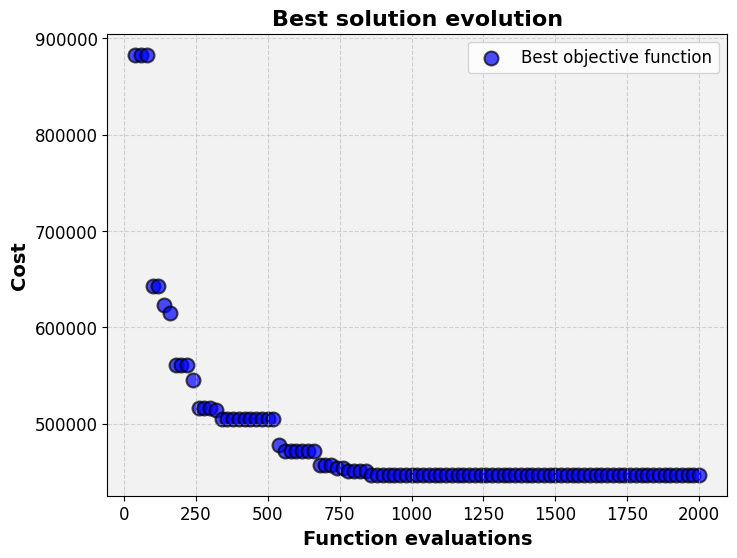

In [10]:
# Create a scatter plot with enhanced styling
plt.figure(figsize=(8, 6))  # Set the figure size

# Create a scatter plot
plt.scatter(number_of_individuals, optimal_values_along_generations, label='Best objective function', color='blue', marker='o', s=100, alpha=0.7, edgecolors='black', linewidths=1.5)

# Add labels and a legend with improved formatting
plt.xlabel('Function evaluations', fontsize=14, fontweight='bold')
plt.ylabel('Cost', fontsize=14, fontweight='bold')
plt.title('Best solution evolution', fontsize=16, fontweight='bold')
plt.legend(loc='upper right', fontsize=12)

# Customize the grid appearance
plt.grid(True, linestyle='--', alpha=0.5)

# Customize the tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add a background color to the plot
plt.gca().set_facecolor('#f2f2f2')

# Show the plot 
plt.show()


## 🏋🏽‍♀️ 2. Genetic algorithm - Exercise

In this case, you will be dealing with the Water Distribution system of the city of Modena, Italy. This network includes three hundred and seventeen pipes, two hundred and sixty-eight demand nodes, and four reservoirs with fixed head within 72.0 m to 74.5 m. The minimum pressure head of all the demand nodes must be maintained at 20 m or higher. The following table shows commercially available diameters and the corresponding unit costs for this network.

| Diameter [mm] |   100 |   125 |   150 |   200 |   250 |   300 |   350 |   400 |   450 |   500 |   600 |   700 |   800 |
|--------------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|
| Cost per meter [€/m] |  27.7 |  38.0 |  40.5 |  55.4 |  75.0 |  92.4 | 123.1 | 141.9 | 169.3 | 191.5 | 246.0 | 319.6 | 391.1 |


<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<b>Task 2.1:</b>   
    In the following cell, define the variables for solving this new problem.
    <ol>
    <li> Define all the relevant variables for solving this new problem. </li> 
    <li> Define the PyMOO model, including the objective function and restrictions.  </li>
    <li> Optimize the model using the genetic algorithm. </li>
    </ol>
</div>

Define the hydraulic model

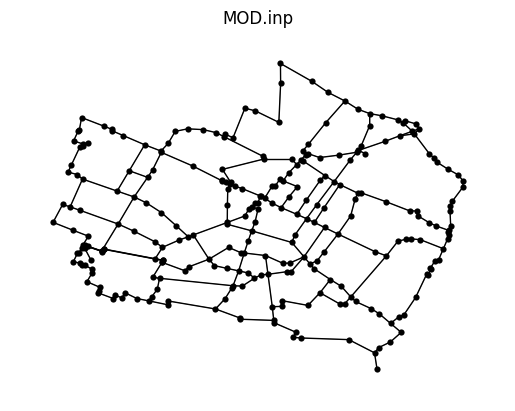

<Axes: title={'center': 'MOD.inp'}>

In [11]:
# Create a water network model
inp_file = 'MOD.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# Graph the network
wntr.graphics.plot_network(wn, title=wn.name)


Define relevant variables and dictionaries

In [12]:
MM_TO_M = 0.001
H_min = 20

cost_function_diameter_mm = {
    100: 27.7,
    125: 38.0,
    150: 40.5,
    200: 55.4,
    250: 75.0,
    300: 92.4,
    350: 123.1,
    400: 141.9,
    450: 169.3,
    500: 191.5,
    600: 246.0,
    700: 319.6,
    800: 391.1
}

pipe_index = {
    0:100,
    1:125,
    2:150,
    3:200,
    4:250,
    5:300,
    6:350,
    7:400,
    8:450,
    9:500,
    10:600,
    11:700,
    12:800,
    }

In [13]:
# def transform_index_to_diameter(matrix_indexes, pipe_index):
#     return np.array([[pipe_index[j] for j in vector_indexes] for vector_indexes in matrix_indexes])

# def transform_diameter_to_cost(matrix_indexes, pipe_index):
#     return np.array([[pipe_index[j] for j in vector_indexes] for vector_indexes in matrix_indexes])

Define the optimization problem

In [14]:
class ModenaOptimization(Problem):
    
    def __init__(self):
        super().__init__(n_var=317, n_obj=1, n_ieq_constr=268, xl=0.0, xu=12.0, vtype=int)

    def _evaluate(self, population, out, *args, **kwargs):

        population_in_diameters = transform_index_to_diameter(population, pipe_index)
        pressure_heads = np.zeros((50, 268))
        individual_costs = np.zeros((50,1))
        # Modify the water network 
        for i, individual in enumerate(population_in_diameters):
            cost = 0
            for j, pipe_name in enumerate(wn.pipe_name_list):
                pipe = wn.get_link(pipe_name)
                pipe.diameter = individual[j] * MM_TO_M
                cost += cost_function_diameter_mm[individual[j]] * pipe.length
            
            individual_costs[i] = cost
            #Simulate the individual
            sim = wntr.sim.EpanetSimulator(wn)
            sim_results = sim.run_sim()

            pressure_heads[i,:]= sim_results.node['pressure'].values[0][:-4] #Excluding the 4 reservoirs
        
        out["F"] = individual_costs
        out["G"] = -(pressure_heads - H_min)



Define the algorithm and optimize

In [15]:
problem = ModenaOptimization()

method = GA(pop_size=50,
            sampling=IntegerRandomSampling(),
            crossover=SBX(prob=1.0, eta=3.0, vtype=float, repair=RoundingRepair()),
            mutation=PM(prob=1.0, eta=3.0, vtype=float, repair=RoundingRepair()),
            eliminate_duplicates=True,
            )

opt_results = minimize(problem,
               method,
               termination=('n_gen', 10),
               seed=1,
               save_history=True,
               verbose=True
               )

print("Best solution found: %s" % opt_results.X)
print("Function value: %s" % opt_results.F)
print("Constraint violation: %s" % opt_results.CV)

n_gen  |  n_eval  |     cv_min    |     cv_avg    |     f_avg     |     f_min    
     1 |       50 |  0.000000E+00 |  1.285498E+02 |  1.014916E+07 |  9.148062E+06
     2 |      100 |  0.000000E+00 |  0.000000E+00 |  9.564942E+06 |  7.338633E+06
     3 |      150 |  0.000000E+00 |  0.000000E+00 |  8.975519E+06 |  7.198541E+06
     4 |      200 |  0.000000E+00 |  0.000000E+00 |  8.398868E+06 |  5.966915E+06
     5 |      250 |  0.000000E+00 |  0.000000E+00 |  7.612148E+06 |  5.611134E+06
     6 |      300 |  0.000000E+00 |  0.000000E+00 |  6.935146E+06 |  5.611134E+06
     7 |      350 |  0.000000E+00 |  0.000000E+00 |  6.572300E+06 |  5.611134E+06
     8 |      400 |  0.000000E+00 |  0.000000E+00 |  6.206625E+06 |  5.114397E+06
     9 |      450 |  0.000000E+00 |  0.000000E+00 |  5.956679E+06 |  5.087090E+06
    10 |      500 |  0.000000E+00 |  0.000000E+00 |  5.657216E+06 |  5.087090E+06
Best solution found: [ 2  1  0  7  2  3  4  2  5  3  5  8  4  2  4  2  5  5  1  4  2  5  1  0  2  

In [ ]:
number_of_individuals = []             
optimal_values_along_generations = []  

for generation_status in opt_results.history:

    try:
        # store the number of function evaluations
        number_of_individuals.append(generation_status.evaluator.n_eval)

        # retrieve the optimum from the algorithm
        optimum = generation_status.opt

        # filter out only the feasible and append and objective space values
        feas = np.where(optimum.get("feasible"))[0]
        optimal_values_along_generations.append(optimum.get("F")[feas][0][0])
    except:
        pass

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<b>Task 2.2: </b>   
    Graphically represent the evolution of the algorithm. Plot the number of individuals as x-axis and optimal values along the generations as y-axis.
</div>

In [ ]:
# Create a scatter plot
plt.figure(figsize=(8, 6))  # Set the figure size

# Create a scatter plot
plt.scatter(number_of_individuals, optimal_values_along_generations, label='Best objective function', color='blue', marker='o', s=100, alpha=0.7, edgecolors='black', linewidths=1.5)

# Add labels and a legend with improved formatting
plt.xlabel('Function evaluations', fontsize=14, fontweight='bold')
plt.ylabel('Cost', fontsize=14, fontweight='bold')
plt.title('Best solution evolution', fontsize=16, fontweight='bold')
plt.legend(loc='upper right', fontsize=12)

# Customize the grid appearance
plt.grid(True, linestyle='--', alpha=0.5)

# Customize the tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add a background color to the plot
plt.gca().set_facecolor('#f2f2f2')

plt.show()


<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<b>Task 2.2:</b>   
    Interpret the results. Imagine you would have to report back these numbers to your materials provider. 
    <ol>
    <li> How much would it cost? </li> 
    <li> What is the minimum pressure at the nodes (excluding the reseivoirs)? </li>
    </ol>
</div>

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<b>Solution</b><br>
<ol> 
    <li> They netwrok would cost 5087089.96 euros.</li>
    <li> The minimum pressure is 20.6 meters.</li>
</ol>
</div>

Check that all the nodes have a pressure head above 20 m.

In [ ]:
optimal_diameters = transform_index_to_diameter([opt_results.X], pipe_index)[0]*MM_TO_M
print(optimal_diameters)

In [ ]:
# Modify the water network
for j, pipe_name in enumerate(wn.pipe_name_list):
    pipe = wn.get_link(pipe_name)
    # Modify the water network 
    pipe.diameter = optimal_diameters[j]
    
#Simulate the individual
sim = wntr.sim.EpanetSimulator(wn)
sim_results = sim.run_sim()

In [ ]:
sim_results.node['pressure']

In [ ]:
sim_results.node['pressure'].values[0][:-4].min()

**End of notebook.**
<h2 style="height: 60px">
</h2>
<h3 style="position: absolute; display: flex; flex-grow: 0; flex-shrink: 0; flex-direction: row-reverse; bottom: 60px; right: 50px; margin: 0; border: 0">
    <style>
        .markdown {width:100%; position: relative}
        article { position: relative }
    </style>
    <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">
      <img alt="Creative Commons License" style="border-width:; width:88px; height:auto; padding-top:10px" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" />
    </a>
    <a rel="TU Delft" href="https://www.tudelft.nl/en/ceg">
      <img alt="TU Delft" style="border-width:0; width:100px; height:auto; padding-bottom:0px" src="https://gitlab.tudelft.nl/mude/public/-/raw/main/tu-logo/TU_P1_full-color.png"/>
    </a>
    <a rel="MUDE" href="http://mude.citg.tudelft.nl/">
      <img alt="MUDE" style="border-width:0; width:100px; height:auto; padding-bottom:0px" src="https://gitlab.tudelft.nl/mude/public/-/raw/main/mude-logo/MUDE_Logo-small.png"/>
    </a>
    
</h3>
<span style="font-size: 75%">
&copy; Copyright 2023 <a rel="MUDE Team" href="https://studiegids.tudelft.nl/a101_displayCourse.do?course_id=65595">MUDE Teaching Team</a> TU Delft. This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.